<a href="https://colab.research.google.com/github/FinanceML/Resampling-Project-VCMF-Conference-/blob/main/vienna_congress_of_mathematical_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from numpy import genfromtxt
my_data = genfromtxt('_ds-cleaned.csv', delimiter=',')

In [ ]:
my_data.shape

(1763, 470)

In [ ]:
import numpy as np
my_data = np.transpose(my_data)
my_data=np.delete(my_data, (0), axis=1)
my_data.shape

(470, 1762)

# Returns

In [ ]:
my_data=(my_data[:,1:]-my_data[:,:-1])/my_data[:,:-1]
my_data.shape

(470, 1761)

In [ ]:
import numpy as np
func= np.vectorize(lambda f1,f2,f3,e: f1*(f2+f3+1)+e)
p=470
#p=79
k=10
L=3
n=1760
#n=201
T=n
m=50

# alpha=np.random.uniform(low=.2, high=.8, size=[k])
# rho=np.random.uniform(low=.2, high=.8, size=[p])
# epsilon=np.random.normal(0,1,size=[T])
# nu=np.random.normal(0,1,size=[p,T])
# e=np.random.normal(0,1,size=[k,T])

#F= my_data
# for j in range(k):
#   for t in range(1,T):
#     F[j,t]=F[j,t-1]*alpha[j]+e[j,t]

# U=np.zeros((p,T))
# for i in range(p):
#   for t in range(1,T):
#     U[i,t]=U[i,t-1]*rho[i]+nu[i,t]

#B=np.random.normal(0,1,size=[p,k])

#y=func(F[1,],F[2,],F[3,],epsilon)
y=my_data[3,0:-1]
X=np.delete(my_data[1:],(3),axis=0)
X=my_data[1:]
y.shape

(1760,)

# Plot the Simulated Series

NameError: ignored

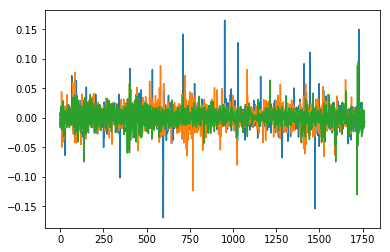

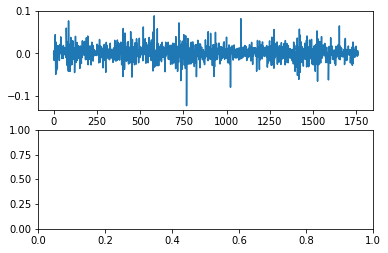

In [ ]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.plot(X[1,])
ax1.plot(X[2,])
ax1.plot(X[3,])
np.shape(X)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.plot(y)
ax3.plot(F[1,])



# Train and Test Decomposition

In [ ]:
n_train=np.int(np.floor(.7*n))
n_valid=np.int(np.floor(.2*n))
n_test=np.int(np.floor(.1*n))
X_train, X_valid, X_test = np.split(X,[n_train , n_train+n_valid],axis=1)
y_train, y_valid, y_test = np.split(y,[n_train , n_train+n_valid],axis=0)

# Extract Factors by PCA

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=k).fit(np.transpose(X_train))
comp=pca.components_
Fhat=np.matmul(comp,X_train)
Fhat_valid=np.matmul(comp,X_valid)
Fhat_test=np.matmul(comp,X_test)

# SF=Fhat
# SF_test=Fhat_test
# Fhat=X_train
# Fhat_test=X_test

# Sliced inverse regression

---



---




In [ ]:
import numpy as np
from numpy import linalg

# Author: Russell Kunes
# Implementing the SIR supervised data reduction method as described in the 1991 paper by Professor Ker-Chau Li


class SIR:
    def __init__(self, K = 2, H = 10, bins = None):
        self.K = K
        self.H = H
        #default is equally spaced bins
        self.bins = bins

    def fit(self, X, Y):
        self.X = X
        self.Y = Y

        #n is the number of observations
        n = X.shape[0]
        p = X.shape[1]

        x_bar = np.mean(X,axis =0)


        #compute the bins, assuming default 
        if self.bins == None:
        	n_h, bins = np.histogram(Y,bins = self.H)
        else: 
        	n_h,bins = np.histogram(Y, bins = self.bins)

        #assign a bin to each observations
        assignments = np.digitize(Y,bins)

        #this is really hacky... 
        assignments[np.argmax(assignments)] -= 1

        #loop through the slices, for each slice compute within slice mean
        M = np.zeros((p,p))
        for i in range(len(n_h)):

        	h = n_h[i]
        	if h != 0:
        		x_h_bar = np.mean(X[assignments == i + 1],axis = 0)
        	elif h ==0:
        		x_h_bar = np.zeros(p)

        	x_std = x_h_bar - x_bar

        	M += float(h) * np.outer(x_std,x_std)

        #compute the estimate of the covariance matrix M
        M  = float(n)**(-1) * M
        self.M = M

        #eigendecomposition of V
        cov = np.cov(X.T)
        V = np.dot(linalg.inv(cov),M)
        eigenvalues, eigenvectors = linalg.eig(V)

        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:,idx]

        #assign first K columns to beta 
        beta = eigenvectors[:,0:self.K]
        self.beta = beta
        self.eigenvalues = eigenvalues
        return


    def transform(self, X_to_predict):
    	beta = self.beta 
    	return np.dot(X_to_predict,beta)



# New LOWESS (SinRas)
Based on the following implementation by `agramfort`

[LOWESS : Locally weighted regression](https://gist.github.com/agramfort/850437)

In [ ]:
from math import ceil

import numpy as np

from scipy import linalg





def lowess(x, y, x_test, f=1. / 40., iter=3):

    """lowess(x, y, f=2./3., iter=3) -> yest



    Lowess smoother: Robust locally weighted regression.

    The lowess function fits a nonparametric regression curve to a scatterplot.

    The arrays x and y contain an equal number of elements; each pair

    (x[i], y[i]) defines a data point in the scatterplot. The function returns

    the estimated (smooth) values of y.



    The smoothing span is given by f. A larger value for f will result in a

    smoother curve. The number of robustifying iterations is given by iter. The

    function will run faster with a smaller number of iterations.

    """

    # Fit LOWESS to Train Data
    ##
    X = np.ones( (len(x),x.shape[1]+1) )
    X[:,1:] = x
    ## Number of Train Samples
    n = len(x)
    r = int(ceil(f * n))
    p = x.shape[1]
    #p_prime = y.shape[1]
    ## Threshold Radius
    h = [ np.sort( np.linalg.norm(x - x[i,:], axis = 1) )[r] for i in range(n) ]
    ## Calculate Mutual Weights
    ### Zero
    w = np.zeros( (n,n) )
    ### Add Distances for Upper Triangle
    for i in range(n):
        for j in range(i+1,n):
            w[i,j] = np.linalg.norm( x[i,:] - x[j,:] )
    ### Add Distances for Lower Triangle
    w += w.T
    ### Divide by Threshold Radius
    w /= h
    ### Clip
    w = np.clip( w, 0.0, 1.0 )
    ### Re-Arrange Weights
    w = (1 - w ** 3) ** 3
    
    #
    yest = np.zeros( n )
    delta = np.ones( n )

    for iteration in range(iter):

        for i in range(n):

            weights = delta * w[:, i]
            
            A = np.matmul( np.matmul( X.T, np.diag(weights) ), X )
            b = np.matmul( np.matmul( X.T, np.diag(weights) ), y )
            
            beta = linalg.solve(A, b)
            
            yest[i] = np.matmul( X[i,:], beta )



        residuals = np.linalg.norm( y - yest, axis = 0 )

        s = np.median( np.abs( residuals ) )

        delta = np.clip(residuals / (6.0 * s), -1, 1)

        delta = (1 - delta ** 2) ** 2
    
    # Predict for x_test
    n_test = len(x_test)
    
    h_test = [np.sort( np.linalg.norm(x - x_test[i], axis = 1) )[r] for i in range(n_test)]
    
    ## Calculate Mutual Weights
    ### Zero
    w_test = np.zeros( (n,n_test) )
    ### Add Distances for Upper Triangle
    for i in range(n):
        for j in range(n_test):
            w_test[i,j] = np.linalg.norm( x[i,:] - x_test[j,:] )
    ### Divide by Threshold Radius
    w_test /= h_test
    ### Clip
    w_test = np.clip( w_test, 0.0, 1.0 )
    ### Re-Arrange Weights
    w_test = (1 - w_test ** 3) ** 3
    
    y_test = np.matmul( w_test.T, yest ) / np.sum( w_test, axis = 0 )
    return y_test


# Selecting $L$ by Validation

##Step 1

In [ ]:
y_train.shape

(1232,)

In [ ]:
import matplotlib.pyplot as plt
eigs = np.zeros((k,1))
eig_mean=np.zeros((k-1,n_train-m))
for L in range(1,k):
  #for L in range(1,k):
  for j in range(n_train-m):
      #start=int(j*n_train/100)
      start=j
      #end=int((j+1)*n_train/100)-1
      end=j+m-1
      sir_ = SIR(K=L,H=10)
      #print(start)
      #print(j)
      sir_.fit(np.transpose(Fhat[:,start:end]),y_train[start:end])
      #SF=sir_.transform(np.transpose(Fhat[:,start:end]))
      #SF=np.transpose(SF)
      eigs=sir_.eigenvalues
      eigs=np.sort(eigs)
      eigs=eigs[::-1]
      eig_mean[L-1,j]=np.average(np.array(eigs[L:k]))
#plt.hist(eig_mean)
#np.mean(eig_mean)
print(eig_mean[:,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


[ 1.53008396e-01  1.07385255e-01  7.74725449e-02  5.51900522e-02
  3.57459483e-02  2.20362470e-02  4.21238822e-03  3.13038522e-17
 -2.26826310e-17]


##Step 2 & 3

In [ ]:
L=3
sir_ = SIR(K=L,H=10)
sir_.fit(np.transpose(Fhat),y_train)
SF=sir_.transform(np.transpose(Fhat))
SF=np.transpose(SF)
SF_valid=sir_.transform(np.transpose(Fhat_valid))
SF_valid=np.transpose(SF_valid)
SF_test=sir_.transform(np.transpose(Fhat_test))
SF_test=np.transpose(SF_test)
eig=sir_.eigenvalues
print(np.shape(Fhat))
print(np.shape(SF_test))
#plt.plot(np.transpose(SF_test))

(10, 1232)
(3, 177)


In [ ]:

import matplotlib.pyplot as plt

#L=3
#sir_ = SIR(K=L,H=10)
#sir_.fit(np.transpose(Fhat_valid),y_valid)
#SF_valid=sir_.transform(np.transpose(Fhat_valid))
#SF_valid=np.transpose(SF_valid)

eigs = np.zeros((k,1))
eig_mean_valid=np.zeros((k-1,n_valid-m))
for L in range(1,k):
  print(L)
  sir_ = SIR(K=L,H=10)
  sir_.fit(np.transpose(Fhat),y_train)
  SF=sir_.transform(np.transpose(Fhat))
  SF=np.transpose(SF)
  y_train_pred=lowess(np.transpose(SF[0:L,:]),y_train,np.transpose(SF[0:L,:]),f=1/50)
  for j in range(n_valid-m):
      #start=int(j*n_train/100)
      start=j
      #end=int((j+1)*n_train/100)-1
      end=j+m-1
      sir_ = SIR(K=L,H=10)
      #print(start)
      #print(j)
      sir_.fit(np.transpose(Fhat[:,start:end]),y_train_pred[start:end])
      eigs=sir_.eigenvalues
      eigs=np.sort(eigs)
      eigs=eigs[::-1]
      eig_mean_valid[L-1,j]=np.average(np.array(eigs[L:k]))
  #print(eig_mean[L-1,])
#plt.hist(eig_mean_valid)
print(eig_mean_valid)

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


2
3
4
5
6
7
8
9
[[ 1.75415553e-01  1.81089512e-01  1.88110249e-01 ...  1.37730226e-01
   1.32801894e-01  1.39281831e-01]
 [ 1.45702247e-01  1.47764090e-01  1.48288866e-01 ...  9.23979085e-02
   9.19379692e-02  9.97057166e-02]
 [ 9.57019298e-02  1.00295061e-01  9.49156261e-02 ...  7.62633561e-02
   7.33239077e-02  6.96333201e-02]
 ...
 [-1.31574354e-17  2.97192345e-17 -2.18960016e-17 ...  3.36490274e-03
   3.61742014e-03  3.77929190e-03]
 [ 4.22860105e-03  2.11461343e-03  2.13595987e-03 ...  3.03523826e-04
   2.14040681e-04  7.29954299e-05]
 [ 2.36083097e-17  2.07959991e-17  4.11350880e-17 ...  8.43946084e-17
  -5.66868314e-17  7.94856646e-18]]


In [ ]:

print(np.mean(eig_mean))
print(np.mean(eig_mean_valid))
print(np.size(eig_mean_valid))

0.04579117210119092
0.056389952860329565
2718


##Step 4

[1.77611347e-02 2.16930922e-55 8.30817742e-41 6.05733865e-39
 5.85614568e-16 4.37966023e-18 1.38234185e-05 1.22222295e-04
 2.30133137e-05]


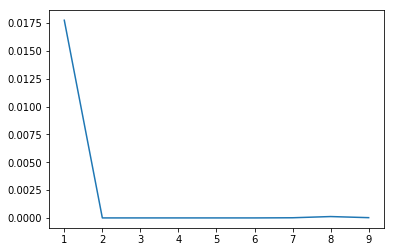

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

x = np.arange(1, k)
pvalue=np.zeros(k-1)

for L in range (1,k):
  test_result=stats.ttest_ind(eig_mean[L-1,:],eig_mean_valid[L-1,:],equal_var=False)
  pvalue[L-1]=test_result.pvalue

plt.plot(x,pvalue)
#stats.ks_2samp(eig_mean,eig_mean_valid)
print(pvalue)

# PCA + SIR + Local

In [ ]:
L=4
sir_ = SIR(K=L,H=10)
sir_.fit(np.transpose(Fhat),y_train)
SF=sir_.transform(np.transpose(Fhat))
SF=np.transpose(SF)
SF_valid=sir_.transform(np.transpose(Fhat_valid))
SF_valid=np.transpose(SF_valid)
SF_test=sir_.transform(np.transpose(Fhat_test))
SF_test=np.transpose(SF_test)
#eig=sir_.eigenvalues
print(np.shape(Fhat))
print(np.shape(SF_test))
#plt.plot(np.transpose(SF_test))

(10, 1232)
(4, 177)


In [ ]:
yq=lowess(np.transpose(SF),y_train,np.transpose(SF_valid),f=1/45)
np.shape(yq)

(352,)


# PCA + Local

In [ ]:
yq=lowess(np.transpose(Fhat),y_train,np.transpose(Fhat_valid),f=1/45)
np.shape(yq)

KeyboardInterrupt: ignored

# Result

0.29250934860305045


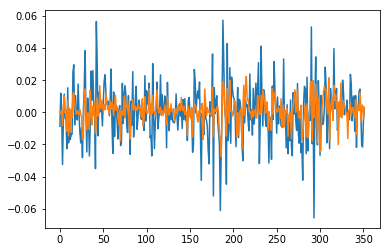

In [ ]:
import matplotlib.pyplot as plt

## In sample
#R2is=1-(np.mean((yq-y_train)**2))/(np.mean((y_train-np.mean(y_train))**2))
#print(R2is)

#fig1, ax1 = plt.subplots()
#ax1.plot(y_train)
#ax1.plot(yq)

## Out of Sample
R2os=1-(np.mean((yq-y_valid)**2))/(np.mean((y_valid-np.mean(y_valid))**2))
print(R2os)

fig1, ax1 = plt.subplots()
ax1.plot(y_valid)
ax1.plot(yq)
#ax1.set_title('PCA+SIR+LinReg')

